# Wordle Difficulty Analysis
**Vince Gregoric**  
**July 1, 2023**

## Overview and Project Goal:
The goal of this project is to create a machine learning model to predict the difficulty of solving Wordle based on the target word. Wordle is a word puzzle where the player has six tries to guess the five-letter solution word. After each guess, the player receives feedback about whether the letters from the guessed word are in the answer or not, and if the letter is in the answer, whether it is in the correct position or not. Wordle was originally created by Josh Wardle, and is now owned by the New York Times. It can be accessed at https://www.nytimes.com/games/wordle/index.html.

To get a sense of the difficulty, we will look at the average score for a large number of players. We can define the score by the number of tries it took to guess the answer (from 1 to 6), with fewer tries corresponding to a better score. If the player failed to guess the word after 6 tries, we will assign a score of 7 (the worst possible score). After averaging the score over many players, a higher average score corresponds to a greater difficulty.

There are several factors that may play a role in how difficult a given word is to guess. For example, we might expect that words which are less common in the English language would result in a higher difficulty. We can also look at whether different letters are present in the word, or whether the word starts with a vowel or not. The final factor we will consider is whether the word contains any letters multiple times. There are other factors that we could use to determine the difficulty, but for the analysis below, we will limit ourselves to the features described above.

The data for this projects comes from the following sources:
- https://twitter.com/WordleStats 
- https://wordfinder.yourdictionary.com/wordle/answers/
- https://github.com/IlyaSemenov/wikipedia-word-frequency/tree/master
- https://en.wikipedia.org/wiki/Letter_frequency

For more information on how the data was obtained from these sources, see the Wordle Data Scraping notebook file (`wordle_data_scraping.ipynb`).


In this notebook, we start by importing the data and creating feature columns. Then, after some exploratory analysis, we build up a machine learning model to predict the difficulty from the features described above. We start with a multiple linear regression model, and then refine it with regularization and ensemble methods. Finally, we summarize our conclusions and suggest some possible methods to improve the model in the future.

# 

## Loading Packages and Data:

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import ascii_lowercase
from urllib.request import urlopen
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV

# Load the data
df = pd.read_csv('wordle_data.csv')
display(df.head())
df.describe(include='all')

,wordle_id,year,month,date,n_players,n_hard_mode,pct_1,pct_2,pct_3,pct_4,pct_5,pct_6,pct_fail,answer,freq,freq_rank
0,202,2022,1,7,80630,1362,1,2,23,39,24,9,1,slump,4782,23667
1,203,2022,1,8,101503,1763,1,5,23,31,24,14,2,crank,4162,25914
2,204,2022,1,9,91477,1913,1,3,13,27,30,22,4,gorge,17987,9915
3,205,2022,1,10,107134,2242,1,4,16,30,30,17,2,query,7659,17411
4,206,2022,1,11,153880,3017,1,9,35,34,16,5,1,drink,43697,5238


,wordle_id,year,month,date,n_players,n_hard_mode,pct_1,pct_2,pct_3,pct_4,pct_5,pct_6,pct_fail,answer,freq,freq_rank
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493,4.930000e+02,493.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,493,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,slump,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
mean,448.389452,2022.271805,5.584178,15.553753,71647.529412,4249.910751,0.427992,5.742394,23.036511,33.460446,23.567951,11.058824,2.596349,NaN,1.003837e+05,37768.549696
std,143.004998,0.445342,3.433976,8.711247,82461.827263,3053.777137,0.733482,4.036491,7.830696,5.290058,6.018092,5.936194,3.891484,NaN,3.931147e+05,54906.308637
min,202.000000,2022.000000,1.000000,1.000000,15554.000000,1362.000000,0.000000,0.000000,4.000000,11.000000,9.000000,2.000000,0.000000,NaN,4.900000e+01,31.000000
25%,325.000000,2022.000000,3.000000,8.000000,21916.000000,2058.000000,0.000000,3.000000,17.000000,30.000000,19.000000,7.000000,1.000000,NaN,1.687000e+03,5859.000000
50%,448.000000,2022.000000,5.000000,15.000000,32172.000000,2968.000000,0.000000,5.000000,23.000000,34.000000,24.000000,10.000000,1.000000,NaN,7.414000e+03,17774.000000
75%,571.000000,2023.000000,8.000000,23.000000,75673.000000,4973.000000,1.000000,7.000000,29.000000,37.000000,28.000000,14.000000,3.000000,NaN,3.758000e+04,45756.000000


# 

## Creating Feature Columns and Target Variable:

Now that we've loaded the data, we can create some new columns. First, we need to calculate the average score to use as the target variable. Then, we need to create feature columns from the answer word. We will look at the following aspects of the answer word:
- The frequency of the word in the English language. This is already present in our DataFrame in the columns `freq` (the number of occurrences of the word on Wikipedia), and `freq_rank` (the ranking of the word given the previous frequency measurement, with lower ranking corresponding to more common words).
- For each letter of the alphabet, whether the answer word contains the letter or not.
- For each letter of the alphabet, how many instances of the letter appear in the answer word.
- Whether the answer word contains any letters multiple times or not.
- Whether the answer word starts with a vowel or not.

Note that for the boolean features described above, we will encode them as integers for use in the machine learning model.

In [2]:
# Calculate the average score
avg_score_lambda = lambda row: (1*row.pct_1 + 2*row.pct_2 + 3*row.pct_3 + 4*row.pct_4 + 5*row.pct_5 +
                                6*row.pct_6 + 7*row.pct_fail)/100
df['avg_score'] = df.apply(avg_score_lambda, axis=1)

# Whether the answer word has a given letter or not
for char in ascii_lowercase:
    has_char = []
    for answer in df.answer:
        if char in answer:
            has_char.append(1) # True
        else:
            has_char.append(0) # False
    df['has_' + char] = has_char

# How many instances of a given letter are in the answer word
for char in ascii_lowercase:
    num_char = []
    for answer in df.answer:
        num_char.append(answer.count(char))
    df['num_' + char] = num_char

# Whether the answer word contains any letters multiple times or not
def repeated_characters(string):
    """Determines if a string contains repeated characters.
    Input:  string to test
    Output: Boolean (True if string has repeated characters, False otherwise)
    """
    repeated = False
    for char in string:
        if string.count(char) > 1:
            repeated = True
    return repeated
df['repeated_chars'] = df.apply(lambda row: int(repeated_characters(row.answer)), axis=1)

# Whether the answer word starts with a vowel or not
vowels = 'aeiou'
df['starts_with_vowel'] = df.apply(lambda row: int(row.answer[0] in vowels), axis=1)


display(df.head())

,wordle_id,year,month,date,n_players,n_hard_mode,pct_1,pct_2,pct_3,pct_4,...,num_s,num_t,num_u,num_v,num_w,num_x,num_y,num_z,repeated_chars,starts_with_vowel
0,202,2022,1,7,80630,1362,1,2,23,39,...,1,0,1,0,0,0,0,0,0,0
1,203,2022,1,8,101503,1763,1,5,23,31,...,0,0,0,0,0,0,0,0,0,0
2,204,2022,1,9,91477,1913,1,3,13,27,...,0,0,0,0,0,0,0,0,1,0
3,205,2022,1,10,107134,2242,1,4,16,30,...,0,0,1,0,0,0,1,0,0,0
4,206,2022,1,11,153880,3017,1,9,35,34,...,0,0,0,0,0,0,0,0,0,0


# 

## Exploratory Analysis:
Before creating a machine learning model, we will do some exploratory analysis to get a feel for the data. First, let's look at the distributions for the different possible scores. 

The first graph created by the cell below is a set of boxplots showing the percent of players to solve the puzzle in a given number of guesses. From this plot, it seems that the most common outcome is to solve the puzzle in four guesses, with a decreasing likelihood as we look at outcomes farther away from four guesses. Solving the puzzle in one guess is very uncommon, which makes sense -- since the player does not have any information about which letters are in the solution, solving the puzzle in one guess would depend almost entirely on luck. Failing to solve the puzzle is also uncommon, with the exception of several outliers. We can assume the outliers correspond to unusually challenging words. Since the data is self-reported, the number of failures is probably underreported (players may not want to tweet their results when they don't solve the puzzle). This means the measured difficulty doesn't necessarily correspond to the true difficulty. However, this issue is present for each word, so it shouldn't negatively impact our machine learning model.

The next set of graphs shows the distribution for each outcome in more detail. Most of the outcomes are skewed -- one guess, two guesses, six guesses, and failed are all skewed right, while four guesses is skewed left. Three guesses and five guesses are fairly normally distributed.

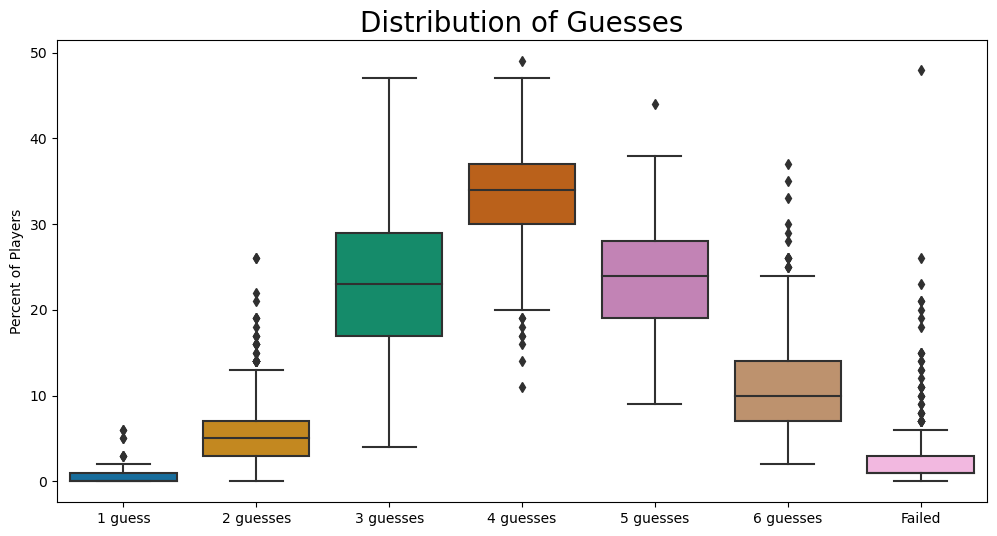

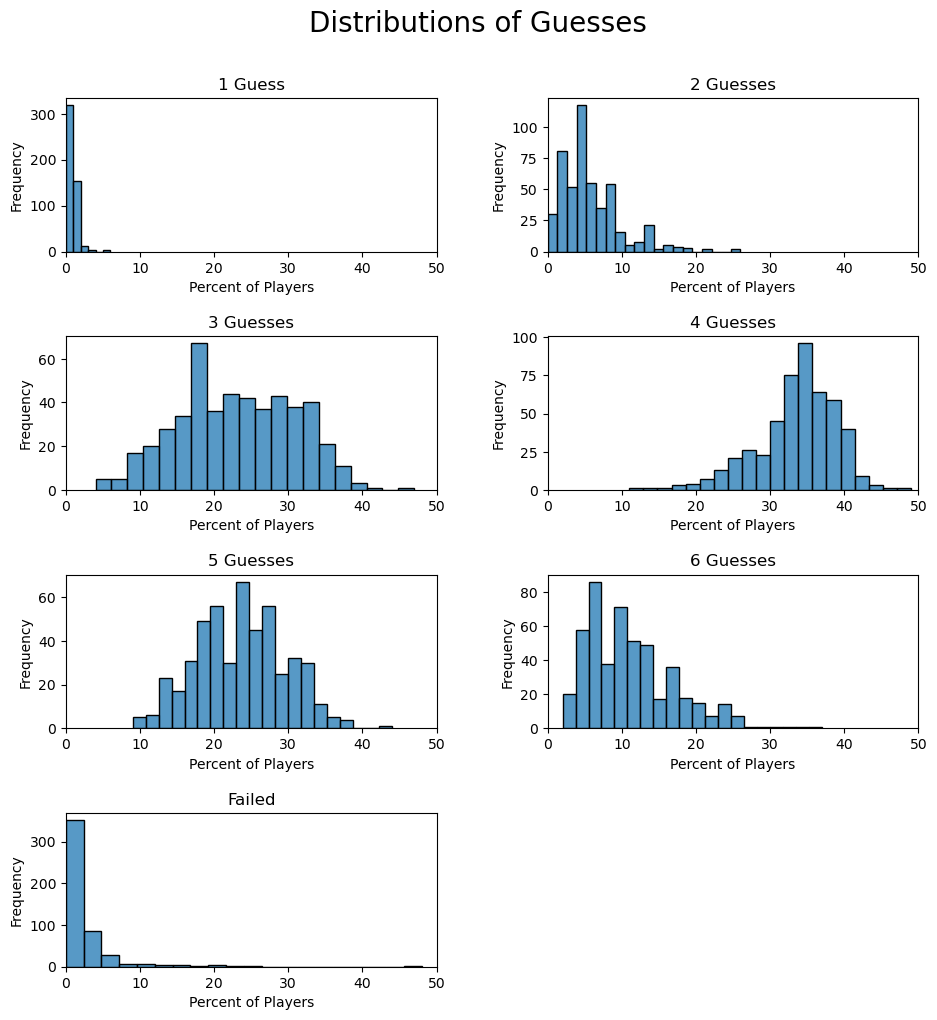

In [3]:
pal = sns.color_palette('colorblind')

# Create boxplots for each possible outcome
score_cols = ['pct_1', 'pct_2', 'pct_3', 'pct_4', 'pct_5', 'pct_6', 'pct_fail']
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(df[score_cols], palette=pal)
plt.xticks(ticks=list(range(7)), labels=['1 guess', '2 guesses', '3 guesses', '4 guesses', '5 guesses',
                                         '6 guesses', 'Failed'])
plt.title('Distribution of Guesses', fontsize=20)
plt.ylabel('Percent of Players')
plt.show()


# # To find an appropriate common range for all the individual histograms:
# max_percent = df[score_cols].max().max()
# min_percent = df[score_cols].min().min()
# print(max_percent, min_percent)
# # Round this range to [0, 50]
x_range = [0, 50]
# # Find the total number of percentages in each score column, to help with setting the number of bins:
# df[score_cols].astype(str).describe(include='all')

# Create histograms for each possible outcome
fig, axs = plt.subplots(4, 2, figsize=(11, 11))
fig.suptitle('Distributions of Guesses', fontsize=20)

sns.histplot(df.pct_1, ax=axs[0][0], bins=6)
axs[0][0].set_title('1 Guess')
axs[0][0].set_xlabel('Percent of Players')
axs[0][0].set_ylabel('Frequency')
axs[0][0].set_xlim(x_range)

sns.histplot(df.pct_2, ax=axs[0][1], bins=20)
axs[0][1].set_title('2 Guesses')
axs[0][1].set_xlabel('Percent of Players')
axs[0][1].set_ylabel('Frequency')
axs[0][1].set_xlim(x_range)

sns.histplot(df.pct_3, ax=axs[1][0], bins=20)
axs[1][0].set_title('3 Guesses')
axs[1][0].set_xlabel('Percent of Players')
axs[1][0].set_ylabel('Frequency')
axs[1][0].set_xlim(x_range)

sns.histplot(df.pct_4, ax=axs[1][1], bins=20)
axs[1][1].set_title('4 Guesses')
axs[1][1].set_xlabel('Percent of Players')
axs[1][1].set_ylabel('Frequency')
axs[1][1].set_xlim(x_range)

sns.histplot(df.pct_5, ax=axs[2][0], bins=20)
axs[2][0].set_title('5 Guesses')
axs[2][0].set_xlabel('Percent of Players')
axs[2][0].set_ylabel('Frequency')
axs[2][0].set_xlim(x_range)

sns.histplot(df.pct_6, ax=axs[2][1], bins=20)
axs[2][1].set_title('6 Guesses')
axs[2][1].set_xlabel('Percent of Players')
axs[2][1].set_ylabel('Frequency')
axs[2][1].set_xlim(x_range)

sns.histplot(df.pct_fail, ax=axs[3][0], bins=20)
axs[3][0].set_title('Failed')
axs[3][0].set_xlabel('Percent of Players')
axs[3][0].set_ylabel('Frequency')
axs[3][0].set_xlim(x_range)

sns.histplot(df.pct_fail, ax=axs[3][1], bins=20)
axs[3][1].set_axis_off()
axs[3][1].set_xlim(1000, 2000)

plt.subplots_adjust(wspace=0.3, hspace=0.55, top=0.9)
plt.show()

# 

Now, let's examine the average score. The first graph below is a histogram of the distribution of average scores. It is approximately normally distributed with a mean of 4.17. The second graph below shows how the average score changes over time. Since there is a new puzzle every day, the Wordle ID number can be viewed as a measure of time. The blue curve is the raw data, and the orange line is the same data smoothed using a 20-day moving average. While there is some fluctuation in the average score, the overall trend is pretty flat, meaning that the average difficulty doesn't change much over time. We can fit a line to this data to see exactly how flat the trend is, but that won't be necessary for our analysis. Since our primary objective is to predict the difficulty given the starting word, we won't be using Wordle ID as one of our features. 

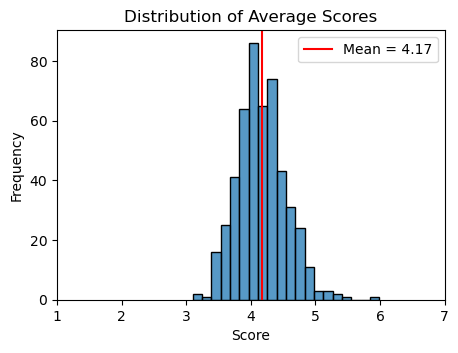

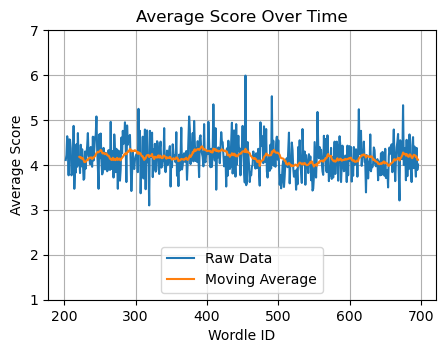

In [4]:
mean_average_score = df.avg_score.mean()

# Create histogram of average scores
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.histplot(df.avg_score, bins=20)
plt.axvline(x=mean_average_score, color='r', label='Mean = ' + str(round(mean_average_score, 2)))
plt.plot()
plt.title('Distribution of Average Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
ax.set_xlim(1,7)
plt.legend()
plt.show()

# Plot average score vs Wordle ID to examine the trend over time
fig, ax = plt.subplots(figsize=(5,3.5))
plt.plot(df.wordle_id, df.avg_score, label='Raw Data')
ax.set_ylim(1,7)
moving_avg_score = df.avg_score.rolling(window=20).mean()
plt.plot(df.wordle_id, moving_avg_score, label='Moving Average')
plt.xlabel('Wordle ID')
plt.ylabel('Average Score')
plt.title('Average Score Over Time')
plt.legend(loc='lower center')
plt.grid()
plt.show()

# 

Now that we've explored the target variable, let's look at some of the features. First, we will use `value_counts` to calculate the percentage of answers that contain repeated characters, and the percentage of answers that start with a vowel:

In [5]:
repeated_chars_percentage = df.repeated_chars.value_counts(normalize=True)
vowel_percentage = df.starts_with_vowel.value_counts(normalize=True)
print('The answer contained repeated characters ' + str(round(100*repeated_chars_percentage[1], 1)) + '% of the time.')
print('The answer started with a vowel ' + str(round(100*vowel_percentage[1], 1)) + '% of the time.')

The answer contained repeated characters 28.0% of the time.
The answer started with a vowel 16.4% of the time.


# 

Now, look at the frequency of each letter for all the answers in the dataset. We can also compare this to the frequency of each letter in the dictionary with data obtained from https://en.wikipedia.org/wiki/Letter_frequency. The first graph below shows the percent occurrence of each letter for both the dataset and the dictionary, while the second graph below shows the difference in these values. For the most part, the frequency in the dataset is pretty close to the frequency in the dictionary, with a largest difference in percent occurrence of 2.37%.

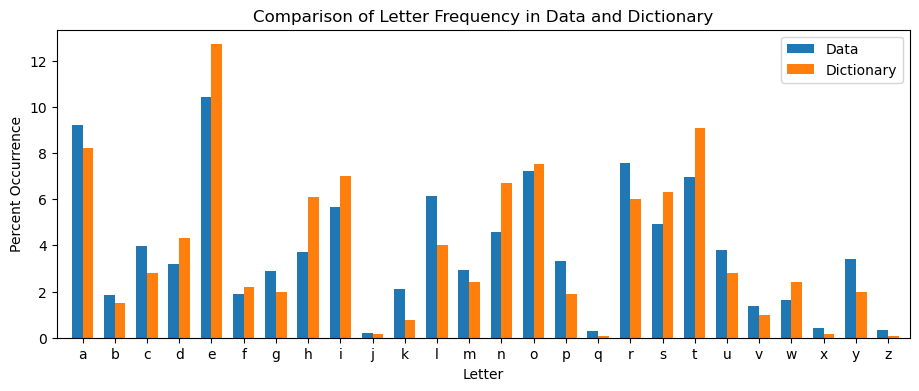

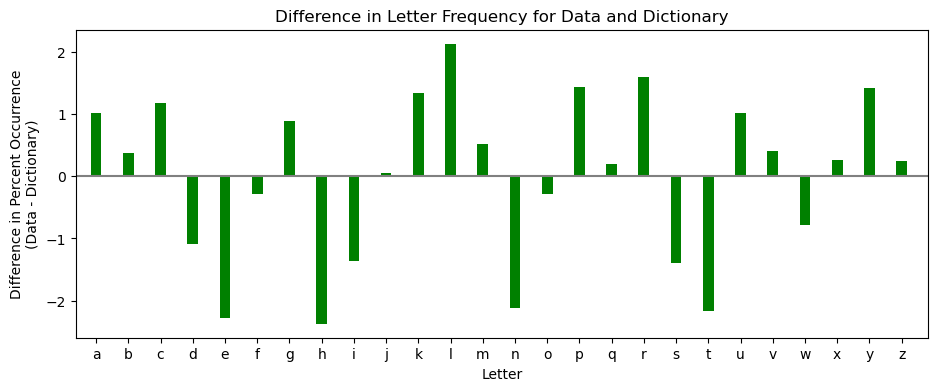

The maximum difference in percent occurrence in the data compared to the dictionary is 2.37%


In [6]:
# Calculate the frequency of each letter for all the answers in the dataset:
letter_freq = pd.DataFrame()
letter_freq['letter'] = list(ascii_lowercase)
count = []
percent = []
for char in ascii_lowercase:
    count.append(df['num_' + char].sum())
    percent.append(100*df['num_' + char].sum()/(5*len(df)))
letter_freq['freq_data'] = count
letter_freq['data_percent'] = percent

# Grab data from Wikipedia on the frequency of letters in the dictionary:
url = 'https://en.wikipedia.org/wiki/Letter_frequency'
page = urlopen(url)
html_bytes = page.read()
html = html_bytes.decode("utf-8").split('\n')
dict_percent = []
lines = list(range(653, 880, 9))
for line in lines:
    freq_index = html[line].index('>') + 1
    freq = html[line][freq_index:-1]
    dict_percent.append(float(freq))
letter_freq['dict_percent'] = dict_percent

# Define function to generate x-coordinates for a side-by-side bar graph:
def xlists_side_by_side_bars(bars_per_set, bar_width, space_width, n_sets):
    """Creates lists of x-values for graphing side-by-side bar plots, helping to visualize the relationship
    between two different categorical variables at once. The bars will be grouped by one variable along the
    x-axis, and the bars within each group will correspond to different categories for the other variable. 
    
    Input:  bars_per_set = the number of bars in each group (number of categories of the second variable)
            bar_width = the width of each bar
            space_width = the width of the space between groups of bars
            n_sets = the number of groups of bars (number of categories for the first variable)
    Output: x_vals: a list of lists, where x_vals[i] is a list of x-coordinates for the bars of the ith
                    category of the second variable (there will be one bar for this category in each group,
                    so that x_vals[i] has a length of n_sets, and x_vals has a length of bars_per_set)
            mid_vals = a list corresponding to the x-values of the labels for each group of bars
    """
    x_vals = []
    mid_vals = []
    for i in range(bars_per_set):
        x_vals.append([bar_width*bars_per_set*x + bar_width*i + space_width*x for x in range(n_sets)])
    for j in range(n_sets):
        mid_vals.append(sum([x_vals[i][j] for i in range(bars_per_set)])/bars_per_set)
    return x_vals, mid_vals


# Graph the percent occurrence of each letter in the data, 
# alongside the percent occurrence of each letter in the dictionary:
width = 0.8
x_vals, mid_vals = xlists_side_by_side_bars(2, width, 0.8, 26)
data_x = x_vals[0]
dict_x = x_vals[1]
fig, ax = plt.subplots(figsize=(11,4))
plt.bar(data_x, letter_freq.data_percent, label='Data')
plt.bar(dict_x, letter_freq.dict_percent, label='Dictionary')
plt.title('Comparison of Letter Frequency in Data and Dictionary');
plt.xlabel('Letter');
plt.xticks(mid_vals)
ax.set_xticklabels(letter_freq.letter)
plt.ylabel('Percent Occurrence');
plt.legend()
ax.set_xlim(-1.5,62)
plt.show()

# Plot the difference in percent occurrence between the data and the dictionary:
fig, ax = plt.subplots(figsize=(11,4))
plt.bar(data_x, letter_freq.data_percent - letter_freq.dict_percent, color='green')
plt.axhline(y=0, color='gray')
plt.title('Difference in Letter Frequency for Data and Dictionary');
plt.xlabel('Letter');
plt.xticks(data_x)
ax.set_xticklabels(letter_freq.letter)
plt.ylabel('Difference in Percent Occurrence\n(Data - Dictionary)');
ax.set_xlim(-1.5,62)
plt.show()

# Find the largest difference in percent occurrence:
max_diff = round(max(abs(letter_freq.data_percent - letter_freq.dict_percent)), 2)
print('The maximum difference in percent occurrence in the data compared to the dictionary is', str(max_diff) + '%')

# 

Before we set up our machine learning model, we should think about what features to use. We shouldn't use both `freq` and `freq_rank`, since these features are correlated. For the same reason, we shouldn't use both `has_a` and `num_a` (and the same for the other 25 letters). To choose between `freq` and `freq_rank`, let's see which has a stronger correlation with the target variable:

In [7]:
lin_reg_freq = LinearRegression()
lin_reg_freq.fit(df[['freq']], df.avg_score)
r2_freq = lin_reg_freq.score(df[['freq']], df.avg_score)

lin_reg_rank = LinearRegression()
lin_reg_rank.fit(df[['freq_rank']], df.avg_score)
r2_rank = lin_reg_rank.score(df[['freq_rank']], df.avg_score)

print('The r-squared value for freq is', r2_freq)
print('The r-squared value for freq_rank is', r2_rank)

The r-squared value for freq is 0.026599554104489775
The r-squared value for freq_rank is 0.05583158836058033


# 

Since `freq_rank` has a higher correlation with `avg_score`, let's choose `freq_rank` for a feature instead of `freq`. Rather than repeating the previous test for `has_a` vs `num_a` and the other 25 letters, let's just choose the 'has' versions of these variables for our features for now. We will also use `repeated_chars` and `starts_with_vowel` for features. The other columns (such as `wordle_id`, `n_players`, etc.) don't have to do with the answer word directly, so we will leave them out of our list of features. The code below creates a list of all the columns we will use as features for the machine learning model.

In [8]:
feature_cols = []
feature_cols.append('freq_rank')
feature_cols.append('repeated_chars')
feature_cols.append('starts_with_vowel')
letter_cols = ['has_' + char for char in ascii_lowercase]
for col in letter_cols:
    feature_cols.append(col)
print(feature_cols)

['freq_rank', 'repeated_chars', 'starts_with_vowel', 'has_a', 'has_b', 'has_c', 'has_d', 'has_e', 'has_f', 'has_g', 'has_h', 'has_i', 'has_j', 'has_k', 'has_l', 'has_m', 'has_n', 'has_o', 'has_p', 'has_q', 'has_r', 'has_s', 'has_t', 'has_u', 'has_v', 'has_w', 'has_x', 'has_y', 'has_z']


# 

## Machine Learning:
We are now ready to set up a machine learning model. First, standardize each feature of the data such that the transformed mean is 0 and the transformed standard deviation is 1. Then, perform a train-test split on the data, with 70% in the training set and 30% in the test set. Note that we are setting a random state in the train-test split for repeatability.

In [9]:
x = df[feature_cols]
y = df.avg_score
scaler = StandardScaler()
x_standardized = pd.DataFrame()
x_standardized[feature_cols] = scaler.fit_transform(x[feature_cols])
x_train, x_test, y_train, y_test = train_test_split(x_standardized, y, test_size=0.3, random_state=1)

# 

Now, let's start with a simple linear regression model. The code block below trains this model and calculates the $R^2$ score for both the training and test data. The $R^2$ value for the training data is 0.506, while the $R^2$ value for the test data is 0.373. Since the $R^2$ is significantly lower for the test set, this model is overfitting the data. Another way to get a feel for the performance of the model is to plot the actual average scores vs the predicted average scores. Ideally, this plot should fall along the line y = x. In the graph below, we see that the data points fall relatively close to this line, but there is still a decent amount of scatter. This is a sign that our model is not performing as well as we would like on the testing data.

Basic OLS Linear Regression:
Training score: 0.5060878533461356
Testing score: 0.3729903863858671


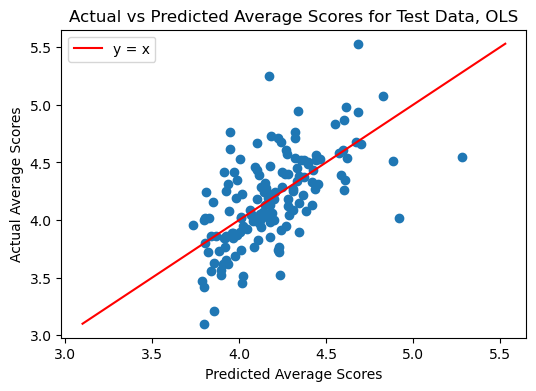

In [10]:
lr_OLS = LinearRegression()
lr_OLS.fit(x_train, y_train)
y_pred = lr_OLS.predict(x_test)

print("Basic OLS Linear Regression:")
print("Training score:", lr_OLS.score(x_train, y_train))
print("Testing score:", lr_OLS.score(x_test, y_test))

min_x = np.minimum(y_pred.min(), y_test.min())
max_x = np.maximum(y_pred.max(), y_test.max())
fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(y_pred, y_test)
plt.plot((min_x, max_x), (min_x, max_x), label='y = x', color='r')
plt.title('Actual vs Predicted Average Scores for Test Data, OLS')
plt.xlabel('Predicted Average Scores')
plt.ylabel('Actual Average Scores')
plt.legend()
plt.show()

# 

To get more insight into the model, let's examine the coefficients. The first graph below shows the relative size of the coefficients for each of our features. Note that a positive coefficient means that a larger value for that feature results in a larger value for average score, and thus a higher difficulty (and vice versa for negative coefficients). For example, `repeated_chars` has the largest positive coefficient, so if the answer word has repeated letters, it tends to be harder to guess. This makes sense, since having fewer than 5 unique letters decreases the chances of the player's guess containing letters in common with the answer. The largest negative coefficient is for the feature `has_t`, so words that contain a *t* are easier to guess. The coefficient for `freq_rank` is large and positive, so words that have a larger frequency rank (less common words) are harder to guess.

Looking at the coefficients for the letter features, it seems that more common letters have more negative coefficients (easier to guess), while less common letters have positive coefficients (harder to guess). The second graph below examines this relationship further by plotting the OLS coefficient vs the letter frequency in the dataset. We can see from this graph that there is indeed a tendency for letters which are more frequent in the dataset to have more negative coefficients.

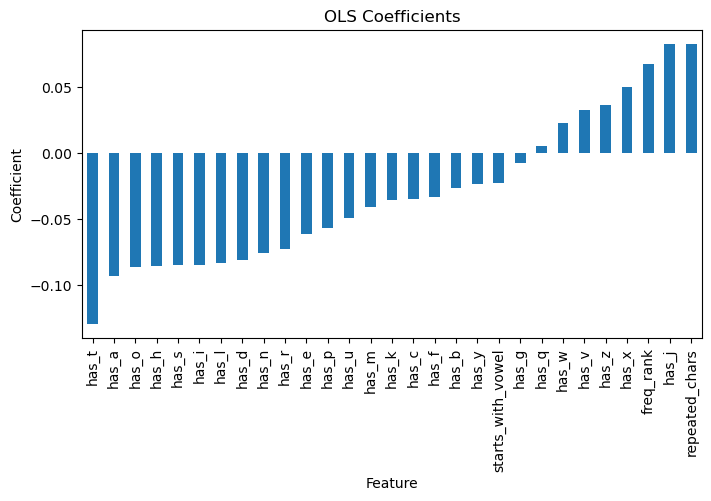

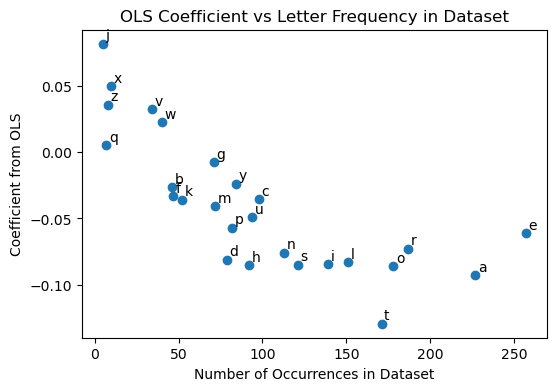

In [11]:
# Plot coefficients in order of size:
coef = pd.Series(lr_OLS.coef_, x_test.columns).sort_values()
plt.figure(figsize = (8,4))
coef.plot(kind='bar', title='OLS Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()

# Look at the relationship between the coefficients and the letter frequency in the dataset:
fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(letter_freq.freq_data, lr_OLS.coef_[-26:])
for i, letter in enumerate(letter_freq.letter):
    ax.annotate(letter, xy=(letter_freq.freq_data[i], lr_OLS.coef_[-26:][i]),
                xytext=(letter_freq.freq_data[i]+1.5, lr_OLS.coef_[-26:][i]+0.003))
plt.title('OLS Coefficient vs Letter Frequency in Dataset')
plt.xlabel('Number of Occurrences in Dataset')
plt.ylabel('Coefficient from OLS')
plt.show()

# 

## Regularization:
Since our basic linear regression model was overfitting the data, we should use regularization to fix this. First, we will implement Lasso (L1) regularization, followed by Ridge (L2) regularization. In each case, we will use `GridSearchCV` to tune the alpha hyperparameter before fitting a final regularized model with the best value of alpha. 

The first graph below visualizes the `GridSearchCV` results for Lasso regularization by plotting the training and test scores as a function of alpha. For the bias-variance tradeoff, we want to find a "sweet spot" where the training and test scores are close to one another, but also are relatively large. `GridSearchCV` finds this sweet spot, which is marked by the "Best α" line in the graph. 

After finding the best value of alpha, we fit a Lasso-regularized linear regression model using this value of alpha. For this model, the training $R^2$ value was 0.485, while the test $R^2$ value was 0.328, so it seems that this regularization is not performing well compared to the unregularized linear model (with Lasso regularization, the training and test scores are farther apart, and lower). Still, it is interesting to compare the coefficients in this regularized model to the coefficients from the unregularized model. From the second graph below, we can see that `repeated_chars` is again the most positive coefficient, but is of greater relative importance. Additionally, seven letters (*p*, *o*, *m*, *k*, *u*, *f*, and *r*) have had their coefficients set to zero, effectively removing these features from the Lasso-regularized model. 


Lasso with GridSearchCV:
Best average training score: 0.3694156896907808
Best value of alpha: 0.010235310218990263


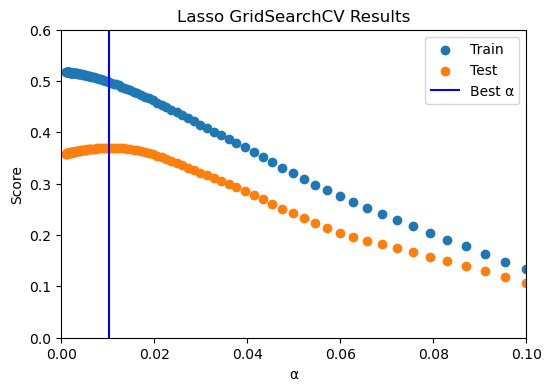


Lasso with best α:
Training score: 0.48530090956693395
Testing score: 0.32793587894232323


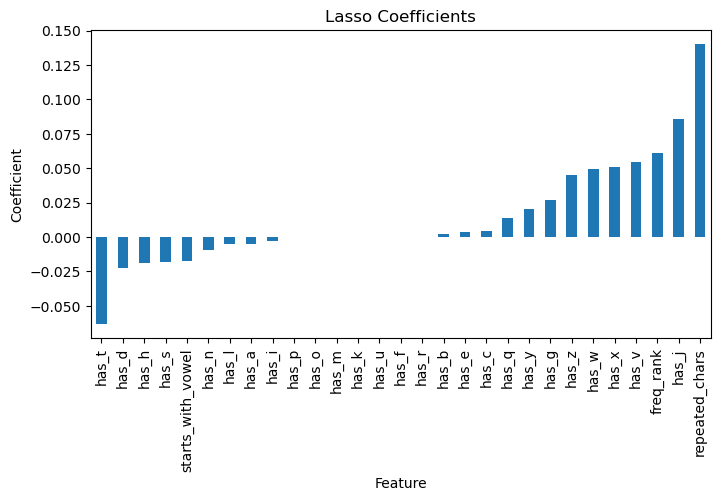

In [12]:
# Lasso

# Hyperparameter tuning using GridSearchCV to find the optimal value of alpha:
alpha_array = np.logspace(-3,-1,100)
alpha_grid = {'alpha':alpha_array}
lasso_cv = GridSearchCV(estimator=Lasso(), param_grid=alpha_grid, cv=5, return_train_score=True)
lasso_cv.fit(x_train, y_train)
results_lasso = pd.DataFrame(lasso_cv.cv_results_)
print('\nLasso with GridSearchCV:')
print('Best average training score:', lasso_cv.best_score_)
print("Best value of alpha:", lasso_cv.best_params_['alpha'])

# Plot the training and test scores as a function of alpha to visualize the CV results:
fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(results_lasso.param_alpha, results_lasso.mean_train_score, label='Train')
plt.scatter(results_lasso.param_alpha, results_lasso.mean_test_score, label='Test')
plt.axvline(lasso_cv.best_params_['alpha'], color='b', label='Best α')
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.6)
plt.title('Lasso GridSearchCV Results')
plt.xlabel('α')
plt.ylabel('Score')
plt.legend()
plt.show()

# Fit a regularized model with the best value of alpha found using GridSearchCV above:
lasso = Lasso(alpha=lasso_cv.best_params_['alpha'])
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)

print("\nLasso with best α:")
print("Training score:", lasso.score(x_train, y_train))
print("Testing score:", lasso.score(x_test, y_test))

# For the final regularized model, plot the coefficients in order of size:
coef = pd.Series(lasso.coef_, x_test.columns).sort_values()
plt.figure(figsize = (8,4))
coef.plot(kind='bar', title='Lasso Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()

# 

The code below repeats the steps above, but for Ridge regularization. For the Ridge-regularized model using the best value of alpha, the training $R^2$ value was 0.495, while the test $R^2$ value was 0.370. These values are both lower than the corresponding values for the unregularized model, but they are slightly closer together. Looking at the coefficients (second graph below), we see that `repeated_chars` has again increased in relative importance. As expected, none of the coefficients are set to zero with Ridge regularization (though `has_u` is very small, it is still nonzero). Overall, both Lasso and Ridge regularization did not make a significant improvement over the unregularized model, so we will have to explore other ways to improve the model.


Ridge with GridSearchCV:
Best average training score: 0.3796532350466028
Best value of alpha: 61.35907273413169


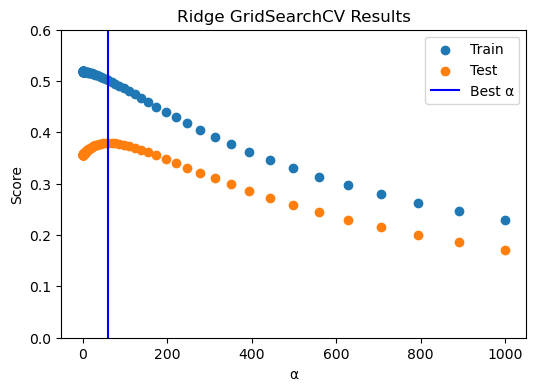


Ridge with best α:
Training score: 0.49477312413236574
Testing score: 0.36967206425765065


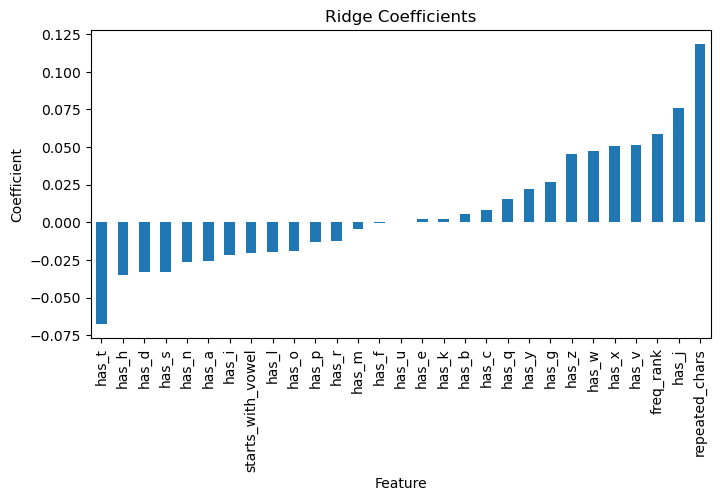

In [13]:
# Ridge:

# Hyperparameter tuning using GridSearchCV to find the optimal value of alpha:
alpha_array = np.logspace(-2,3,100)
alpha_grid = {'alpha':alpha_array}
ridge_cv = GridSearchCV(estimator=Ridge(), param_grid=alpha_grid, cv=5, return_train_score=True)
ridge_cv.fit(x_train, y_train)
results_ridge = pd.DataFrame(ridge_cv.cv_results_)
print('\nRidge with GridSearchCV:')
print('Best average training score:', ridge_cv.best_score_)
print("Best value of alpha:", ridge_cv.best_params_['alpha'])

# Plot the training and test scores as a function of alpha to visualize the CV results:
fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(results_ridge.param_alpha, results_ridge.mean_train_score, label='Train')
plt.scatter(results_ridge.param_alpha, results_ridge.mean_test_score, label='Test')
plt.axvline(ridge_cv.best_params_['alpha'], color = 'b', label = 'Best α')
ax.set_ylim(0, 0.6)
plt.title('Ridge GridSearchCV Results')
plt.xlabel('α')
plt.ylabel('Score')
plt.legend()
plt.show()

# Fit a regularized model with the best value of alpha found using GridSearchCV above:
ridge = Ridge(alpha=ridge_cv.best_params_['alpha'])
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

print("\nRidge with best α:")
print("Training score:", ridge.score(x_train, y_train))
print("Testing score:", ridge.score(x_test, y_test))

# For the final regularized model, plot the coefficients in order of size:
coef = pd.Series(ridge.coef_, x_test.columns).sort_values()
plt.figure(figsize = (8,4))
coef.plot(kind='bar', title='Ridge Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()

# 

## Ensemble Method: Bagging
Another way we can correct the overfitting is to use an ensemble method. Specifically, we should use a Bagging algorithm since our base model (linear regression) is overfit. Since the Lasso and Ridge regularization didn't improve the model much, we will just use the basic linear regression as the base model. Below, we implement a Bagging algorithm using a cross-validation search for the best values of the `max_features` and `max_samples` hyperparameters. After the cross-validation, the best Bagging model has a training $R^2$ value of 0.491 and a test $R^2$ value of 0.380. This represents a slight improvement over the single linear regression model, since the test score increased, and the difference between the training and test scores decreased. However, this model still seems to be overfitting the data. 

In [39]:
# Run a GridSearchCV on the bagging model to determine the best values for the hyperparameters
max_features_array = np.linspace(0.05, 0.95, 19)
max_samples_array = np.linspace(0.05, 0.95, 19)
parameter_grid = {'max_features':max_features_array, 'max_samples':max_samples_array}
bagging_cv = GridSearchCV(estimator=BaggingRegressor(LinearRegression(), n_estimators=500, random_state=1), 
                     param_grid=parameter_grid, cv=5, return_train_score=True)
bagging_cv.fit(x_train, y_train)
results_bagging = pd.DataFrame(bagging_cv.cv_results_)
print('\nBagging Model with GridSearchCV:')
print('Best average training score:', bagging_cv.best_score_)
print("Best value of max_samples:", bagging_cv.best_params_['max_samples'])
print("Best value of max_features:", bagging_cv.best_params_['max_features'])


# Fit a final bagging model with the best values of the hyperparameters found using GridSearchCV above:
bagging_best = BaggingRegressor(LinearRegression(), n_estimators=500, random_state=1,
                                max_samples=bagging_cv.best_params_['max_samples'],
                                max_features=bagging_cv.best_params_['max_features'])
bagging_best.fit(x_train, y_train)
y_pred = bagging_best.predict(x_test)

print("\nBest Bagging Model:")
print("Training score:", bagging_best.score(x_train, y_train))
print("Testing score:", bagging_best.score(x_test, y_test))


Bagging Model with GridSearchCV:
Best average training score: 0.37487211169375356
Best value of max_samples: 0.85
Best value of max_features: 0.7999999999999999

Best Bagging Model:
Training score: 0.49119345708165496
Testing score: 0.38036811821043837


# 

## Conclusions and Future Work:
In this notebook, we have created a machine learning model to predict the difficulty of solving a Wordle puzzle given the answer word. We started with a basic linear regression model, which turned out to be overfit. To correct this overfitting, we tried Lasso and Ridge regularization, as well as a Bagging ensemble model. While regularization did not seem to have much of an effect, the Bagging model did produce a slight improvement to the overfitting. 

There are several things we can do to try to improve the model from here. For example, we can try using different features, such as `num_a` rather than `has_a`. One way to decide which feature to use would be to calculate the correlation between the target variable and `num_a`, and compare this to the correlation between the target variable and `has_a` (like we did above with `freq` and `freq_rank`). We could also use automated feature selection methods such as sequential forward/backward selection or recursive feature elimination to attempt to find a more predictive combination of features. It might be helpful to consider new types of features altogether. For instance, we could include the part of speech of the answer word, or look at bigrams of two letters at a time to see if having certain *combinations* of letters in the answer word affects the difficulty. While it makes sense to use the average score as a measure of difficulty for our target variable, it might be easier to develop a classifying machine learning model rather than a regression model. In this case, we could turn the average score into a categorical variable (e.g., is the average score greater than 4 or not?). Finally, we can try different machine learning models rather than linear regression, such as a decision tree or a k-nearest neighbors algorithm. 